### Notebook to investigate tSNE embedding space from results

In [9]:
%matplotlib inline
import os
import cv2
import re
import gc
import sys
import math
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.data import parallel_interleave

from sklearn.cluster import AgglomerativeClustering as HAC
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as ARS
from sklearn.metrics import completeness_score as CLS
from sklearn.metrics import  homogeneity_score as HS
from sklearn.metrics.pairwise import cosine_similarity 

from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import euclidean_distances

In [201]:
def data_extractor_resize_fn(filelist,prefetch=1,height=32,width=32,channel=6,read_threads=4, distribute=(1, 0)):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """
        features = {
            "shape": tf.FixedLenFeature([3], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        # conversion of tensor
        patch = tf.cast(patch, tf.float32)
        patch = tf.image.resize_images(patch, (height, width))
        return patch
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patches_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch = sess.run(next_element)
                patches_list.append(patch)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patches_list

In [3]:
def comp_tsne(encs):
    n,h,w,c = encs.shape
    feat2d = TSNE(n_components=2).fit_transform(encs.reshape(n, h*w*c))
    return feat2d

In [4]:
def pkl_loader(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [11]:
def file_getter(basedatadir=None, expname=None, nclusters=None, cexpname=None,score_only=True):
    """ TODO in future specify clustering expname"""
    datadir = os.path.join(basedatadir, f"{expname}/nclusters-{nclusters}/HAC")
    try:
        tmp = glob.glob(os.path.join(datadir, f'*{cexpname}.pkl'))
        a = [i for i in tmp]
        print("Begin loading result files")
    except Exception as e:
        print(e)
        
    scores =  pkl_loader(
            glob.glob(os.path.join(datadir, f"score-hac_{cexpname}.pkl"))[0]
    )
    if not score_only:
        #omodel =  pkl_loader(
        #    glob.glob(os.path.join(datadir, f"original-hac_{cexpname}.pkl"))[0]
        #)
        #rmodel =  pkl_loader(
        #    glob.glob(os.path.join(datadir, f"reprot-hac_{cexpname}.pkl"))[0]
        #)
        oencs = np.load( glob.glob(os.path.join(datadir, f"oencs-hac_{cexpname}_nc-{nclusters}.npy"))[0])
        rencs = np.load( glob.glob(os.path.join(datadir, f"rencs-hac_{cexpname}_nc-{nclusters}.npy"))[0])
        #return scores, omodel, rmodel, 
        return scores, oencs, rencs 
    else:
        return scores

In [81]:
def file_getter2(basedatadir=None, expname=None, nclusters=None, cexpname=None,score_only=True):
    """ TODO in future specify clustering expname"""
    datadir = os.path.join(basedatadir, f"{expname}/nclusters-{nclusters}/HAC")
    try:
        tmp = glob.glob(os.path.join(datadir, f'*{cexpname}.pkl'))
        a = [i for i in tmp]
        print("Begin loading result files")
    except Exception as e:
        print(e)
        
    scores =  pkl_loader(
            glob.glob(os.path.join(datadir, f"score-hac_{cexpname}.pkl"))[0]
    )
    if not score_only:
        omodel =  pkl_loader(
            glob.glob(os.path.join(datadir, f"original-hac_{cexpname}.pkl"))[0]
        )
        rmodel =  pkl_loader(
            glob.glob(os.path.join(datadir, f"reprot-hac_{cexpname}.pkl"))[0]
        )
        #oencs = np.load( glob.glob(os.path.join(datadir, f"oencs-hac_{cexpname}_nc-{nclusters}.npy"))[0])
        #rencs = np.load( glob.glob(os.path.join(datadir, f"rencs-hac_{cexpname}_nc-{nclusters}.npy"))[0])
        return scores, omodel, rmodel
        #return scores, oencs, rencs 
    else:
        return scores

#### Load dataset 

In [7]:
basedatadir = "./large_hac9"

- Large_hac9

In [51]:
# cpy = 12
scoreRI2000, oriencs, riencs = file_getter(basedatadir=basedatadir, expname='4678889', cexpname="4773990",
                                          nclusters=2000, score_only=False)
scoreRI2000

Begin loading result files


{'nclusters-2000': {'ami': -0.002516503394418826,
  'nmi': 0.5856085644919373,
  'cls': 0.6275633086809707,
  'hs': 0.5489119326194334,
  'ars': -0.00034779297383319375}}

In [72]:
# cpy = 4
scoreRI4, oriencs, riencs = file_getter(basedatadir=basedatadir, expname='4678889', cexpname="4782144",
                                          nclusters=4, score_only=False)
scoreRI4

Begin loading result files


{'nclusters-4': {'ami': 0.3142439781943283,
  'nmi': 0.3149422317694979,
  'cls': 0.3175863597938169,
  'hs': 0.3123417686257881,
  'ars': 0.1811141507562992}}

In [84]:
# cpy = 4
_x, ori_model, ri_model = file_getter2(basedatadir=basedatadir, expname='4678889', cexpname="4782144",
                                          nclusters=4, score_only=False)

Begin loading result files


In [97]:
# cpy = 2
scoreRI2, oriencs, riencs = file_getter(basedatadir=basedatadir, expname='4678889', cexpname="4783180",
                                          nclusters=2, score_only=False)
scoreRI2

Begin loading result files


{'nclusters-2': {'ami': -0.00021932275551326996,
  'nmi': 0.0,
  'cls': 0.0,
  'hs': 0.0,
  'ars': -0.00013782844642577904}}

In [98]:
# cpy = 2
_x, ori_model, ri_model = file_getter2(basedatadir=basedatadir, expname='4678889', cexpname="4783180",
                                          nclusters=2, score_only=False)

Begin loading result files


In [43]:
scoreRI2000, oriencs, riencs = file_getter(basedatadir=basedatadir, expname='4678889', cexpname="4773456",
                                          nclusters=2000, score_only=False)
scoreRI2000

Begin loading result files


{'nclusters-2000': {'ami': -0.0012935982158572186,
  'nmi': 0.8617517811884804,
  'cls': 0.9005878010493593,
  'hs': 0.8261267432189764,
  'ars': -0.00044154044366537725}}

In [47]:
scoreNRI2000, onriencs, nriencs = file_getter(basedatadir=basedatadir, expname='m2_02_global_2000_2018_band28_29_31', 
                                              cexpname="4773463", nclusters=2000, score_only=False)
scoreNRI2000

Begin loading result files


{'nclusters-2000': {'ami': 0.19733657752603262,
  'nmi': 0.8888248691633197,
  'cls': 0.9292622935997635,
  'hs': 0.8517600048393292,
  'ars': 0.07097280522570219}}

In [91]:
# cpy = 4
scoreNRI4, onriencs, nriencs = file_getter(basedatadir=basedatadir,expname='m2_02_global_2000_2018_band28_29_31',
                                           cexpname="4782182",nclusters=4, score_only=False)
scoreNRI4

Begin loading result files


{'nclusters-4': {'ami': 0.6696601252795955,
  'nmi': 0.6699802994304116,
  'cls': 0.6685360647086758,
  'hs': 0.6714307876058333,
  'ars': 0.7277729489599325}}

In [92]:
# cpy = 4
_x, onri_model, nri_model = file_getter2(basedatadir=basedatadir,expname='m2_02_global_2000_2018_band28_29_31',
                                           cexpname="4782182",nclusters=4, score_only=False)

Begin loading result files


In [103]:
# cpy = 2
scoreNRI2, onriencs, nriencs = file_getter(basedatadir=basedatadir,expname='m2_02_global_2000_2018_band28_29_31',
                                           cexpname="4783158",nclusters=2, score_only=False)
scoreNRI2

Begin loading result files


{'nclusters-2': {'ami': 0.65691808391498,
  'nmi': 0.6570024160108502,
  'cls': 0.6347766590573273,
  'hs': 0.6808410487938285,
  'ars': 0.7927740509218781}}

In [104]:
# cpy = 2
_x, onri_model, nri_model = file_getter2(basedatadir=basedatadir,expname='m2_02_global_2000_2018_band28_29_31',
                                           cexpname="4783158",nclusters=2, score_only=False)

Begin loading result files


###### Large_hac10

In [111]:
basedatadir = "./large_hac10"

In [195]:
# copy == 90
scoreRI90, oriencs, riencs = file_getter(basedatadir=basedatadir, expname='4678889', cexpname="4784687",
                                          nclusters=90, score_only=False)
scoreRI90

Begin loading result files


{'nclusters-90': {'ami': 0.16392656087709956,
  'nmi': 0.25199428338867264,
  'cls': 0.2506947623386362,
  'hs': 0.25330734723889053,
  'ars': 0.023106680130773747}}

In [113]:
# cpy = 90
_x, ori_model, ri_model = file_getter2(basedatadir=basedatadir,expname='4678889',
                                           cexpname="4784687",nclusters=90, score_only=False)

Begin loading result files


In [159]:
# copy == 90
scoreNRI90, onriencs, nriencs = file_getter(basedatadir=basedatadir, expname='m2_02_global_2000_2018_band28_29_31',
                                          cexpname="4791779",nclusters=90, score_only=False)
scoreNRI90

Begin loading result files


{'nclusters-90': {'ami': 0.3242920717095339,
  'nmi': 0.3959838107289848,
  'cls': 0.3981101195991296,
  'hs': 0.3938800944520656,
  'ars': 0.11412438167135627}}

In [154]:
# cpy = 90
_x, onri_model, nri_model = file_getter2(basedatadir=basedatadir,expname='m2_02_global_2000_2018_band28_29_31',
                                           cexpname="4791779",nclusters=90, score_only=False)

Begin loading result files


In [196]:
riencs.shape

(9000, 2, 2, 512)

Latent representations

In [114]:
# RI encoder
ori_feat2d = comp_tsne(oriencs)
ri_feat2d = comp_tsne(riencs)

In [160]:
# NRI encoder
onri_feat2d = comp_tsne(onriencs)
nri_feat2d = comp_tsne(nriencs)

##### Visualization
Check distribution based on rotations

In [54]:
from pylab import *
def get_colors(cmap_name=None, ndiv=-1):
    cmap = cm.get_cmap(cmap_name, ndiv)    # PiYG
    colors = []
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        colors.append(matplotlib.colors.rgb2hex(rgb))
    return colors

- Copy size == 12

In [68]:
ri_feat2d[x[0][0],0]

2.1755638

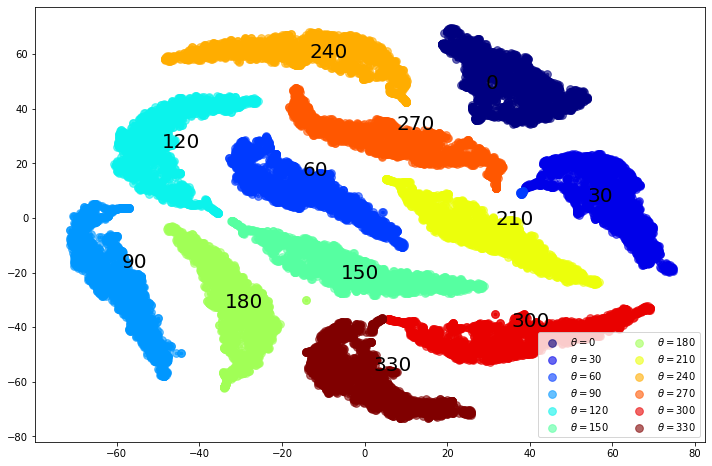

In [70]:
colors =  get_colors('jet', 12)  #np.arange(0,12,1)
plt.figure(figsize=(12,8))
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
degs = np.linspace(0,360,len(colors)+1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(ri_feat2d[x,0], ri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
    plt.scatter(ri_feat2d[x[0],0], ri_feat2d[x[0],1], color=colors[idx], s=60, alpha=0.6, label=fr'$\theta={int(degs[idx])}$')
    plt.text(ri_feat2d[x[0][0],0], ri_feat2d[x[0][0],1],s=f"{int(degs[idx])}", fontsize=20)
plt.legend(ncol=2)
plt.show()

- Copy size == 90 ncluster == 90

RI

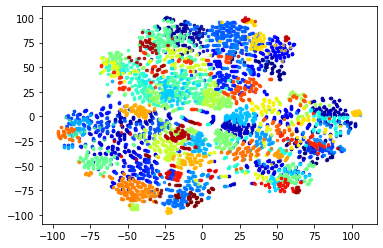

In [138]:
ori_labels =ori_model.labels_
colors = get_colors('jet',90)
plt.figure()
xlist = []
nclusters = 90
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where( ori_labels  == i)
    plt.scatter(ori_feat2d[x,0], ori_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

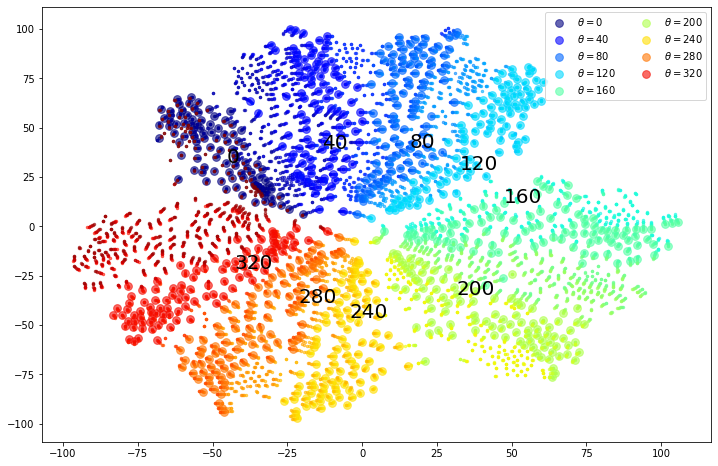

In [136]:
colors =  get_colors('jet', 90)  #np.arange(0,12,1)
plt.figure(figsize=(12,8))
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
degs = np.linspace(0,360,len(colors)+1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    plt.scatter(ori_feat2d[x,0], ori_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
    if idx % 10 == 0:
        plt.scatter(ori_feat2d[x[0],0], ori_feat2d[x[0],1], color=colors[idx], s=60, alpha=0.6, label=fr'$\theta={int(degs[idx])}$')
        plt.text(ori_feat2d[x[0][0],0], ori_feat2d[x[0][0],1],s=f"{int(degs[idx])}", fontsize=20)
plt.legend(ncol=2)
plt.show()

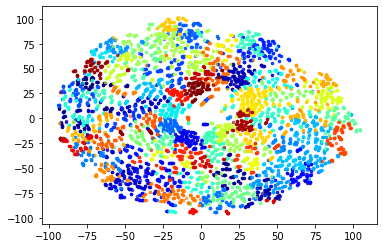

In [139]:
ri_labels = ri_model.labels_
colors = get_colors('jet',90)
plt.figure()
xlist = []
nclusters = 90
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where( ri_labels  == i)
    plt.scatter(ri_feat2d[x,0], ri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

NRI

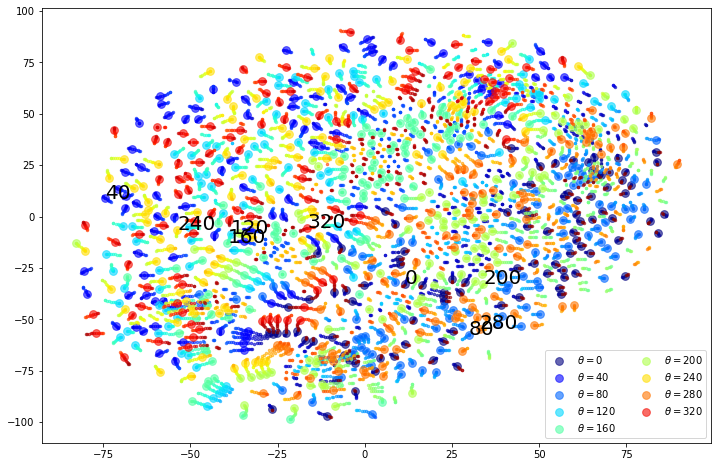

In [161]:
colors =  get_colors('jet', 90)  #np.arange(0,12,1)
plt.figure(figsize=(12,8))
xlist = []
xdx = np.arange(0,onriencs.shape[0],1)
degs = np.linspace(0,360,len(colors)+1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    plt.scatter(onri_feat2d[x,0], onri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
    if idx % 10 == 0:
        plt.scatter(onri_feat2d[x[0],0], onri_feat2d[x[0],1], color=colors[idx], s=60, alpha=0.6, label=fr'$\theta={int(degs[idx])}$')
        plt.text(onri_feat2d[x[0][0],0], onri_feat2d[x[0][0],1],s=f"{int(degs[idx])}", fontsize=20)
plt.legend(ncol=2)
plt.show()

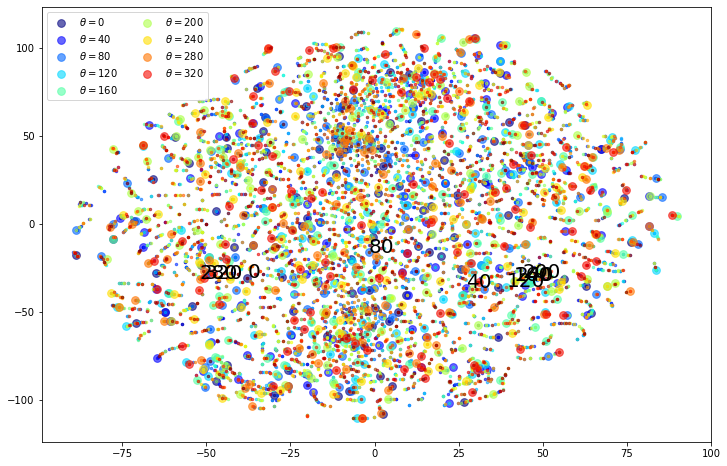

In [164]:
colors =  get_colors('jet', 90)  #np.arange(0,12,1)
plt.figure(figsize=(12,8))
xlist = []
xdx = np.arange(0,onriencs.shape[0],1)
degs = np.linspace(0,360,len(colors)+1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    plt.scatter(nri_feat2d[x,0], nri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
    if idx % 10 == 0:
        plt.scatter(nri_feat2d[x[0],0], nri_feat2d[x[0],1], color=colors[idx], s=60, alpha=0.6, label=fr'$\theta={int(degs[idx])}$')
        plt.text(nri_feat2d[x[0][0],0], nri_feat2d[x[0][0],1],s=f"{int(degs[idx])}", fontsize=20)
plt.legend(ncol=2)
plt.show()

In [162]:
nri_feat2d.shape, ri_feat2d.shape

((9000, 2), (9000, 2))

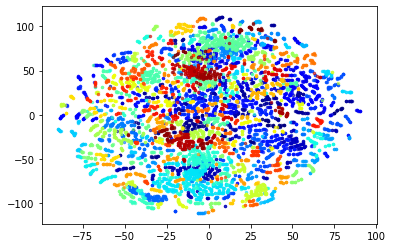

In [163]:
nri_labels = nri_model.labels_
colors = get_colors('jet',90)
plt.figure()
xlist = []
nclusters = 90
xdx = np.arange(0,nriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where(nri_labels  == i)
    plt.scatter(nri_feat2d[x,0], nri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

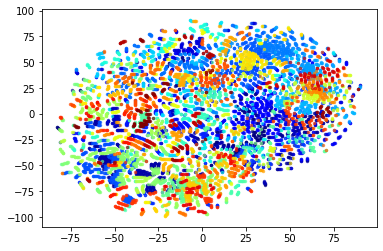

In [165]:
onri_labels = onri_model.labels_
colors = get_colors('jet',90)
plt.figure()
xlist = []
nclusters = 90
xdx = np.arange(0,nriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where(onri_labels  == i)
    plt.scatter(onri_feat2d[x,0], onri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

- Copy size == 2 ncluster == 2

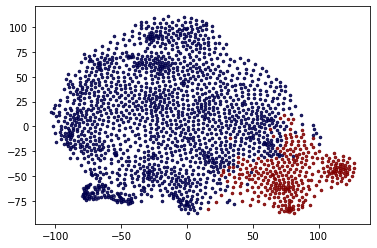

In [101]:
ori_labels = ori_model.labels_
colors = get_colors('seismic',2)
plt.figure()
xlist = []
nclusters = 2
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where( ori_labels  == i)
    plt.scatter(ori_feat2d[x,0], ori_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

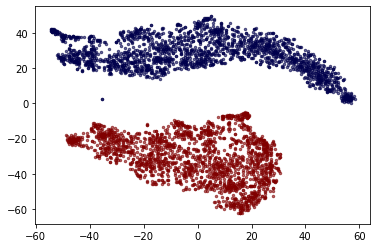

In [102]:
ri_labels = ri_model.labels_
colors = get_colors('seismic',2)
plt.figure()
xlist = []
nclusters = 2
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where( ri_labels  == i)
    plt.scatter(ri_feat2d[x,0], ri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

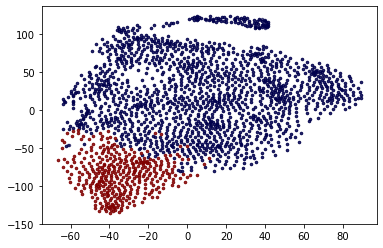

In [106]:
onri_labels = onri_model.labels_
colors = get_colors('seismic',2)
plt.figure()
xlist = []
nclusters = 2
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where( onri_labels  == i)
    plt.scatter(onri_feat2d[x,0], onri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

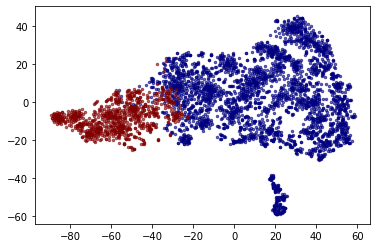

In [107]:
nri_labels = nri_model.labels_
colors = get_colors('jet',2)
plt.figure()
xlist = []
nclusters = 2
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where( nri_labels  == i)
    plt.scatter(nri_feat2d[x,0], nri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

- Copy size == 2 and ncluster == 4

RI

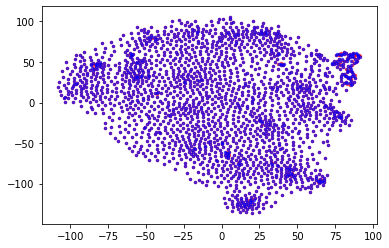

In [78]:
colors = ['red', 'blue']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    plt.scatter(ori_feat2d[x,0], ori_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

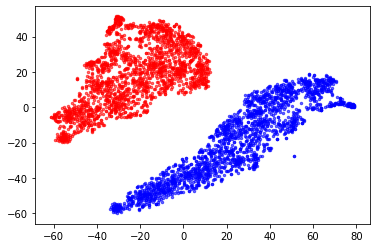

In [74]:
colors = ['red', 'blue']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(ri_feat2d[x,0], ri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

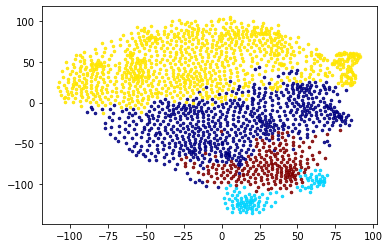

In [86]:
ori_labels = ori_model.labels_
colors = get_colors('jet',4)
plt.figure()
xlist = []
nclusters = 4
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where( ori_labels  == i)
    plt.scatter(ori_feat2d[x,0], ori_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

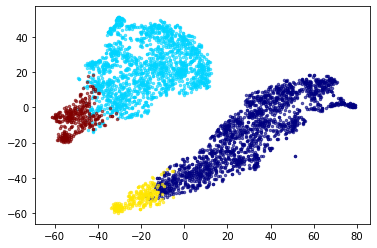

In [87]:
ri_labels = ri_model.labels_
colors = get_colors('jet',4)
plt.figure()
xlist = []
nclusters = 4
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where( ri_labels  == i)
    plt.scatter(ri_feat2d[x,0], ri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

NRI

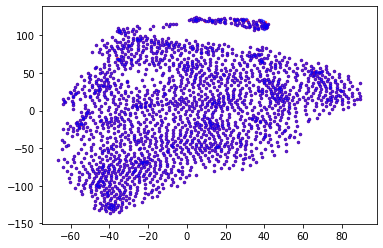

In [93]:
colors = ['red', 'blue']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    plt.scatter(onri_feat2d[x,0], onri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

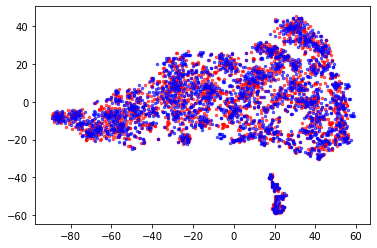

In [94]:
colors = ['red', 'blue']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(nri_feat2d[x,0], nri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

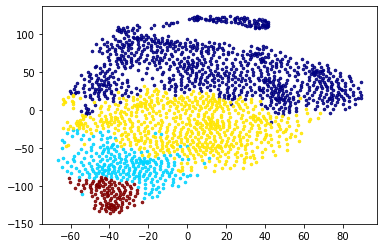

In [95]:
onri_labels = onri_model.labels_
colors = get_colors('jet',4)
plt.figure()
xlist = []
nclusters = 4
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where( onri_labels  == i)
    plt.scatter(onri_feat2d[x,0], onri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

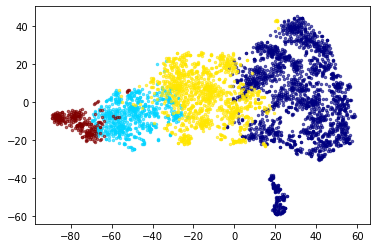

In [96]:
nri_labels = nri_model.labels_
colors = get_colors('jet',4)
plt.figure()
xlist = []
nclusters = 4
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(nclusters)):
    x = np.where( nri_labels  == i)
    plt.scatter(nri_feat2d[x,0], nri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

- Copy size == 2

RI

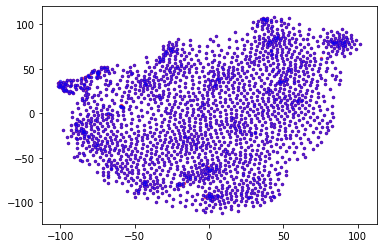

In [45]:
colors = ['red', 'blue']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(ori_feat2d[x,0], ori_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

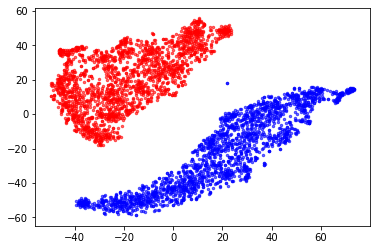

In [46]:
colors = ['red', 'blue']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(ri_feat2d[x,0], ri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

NRI

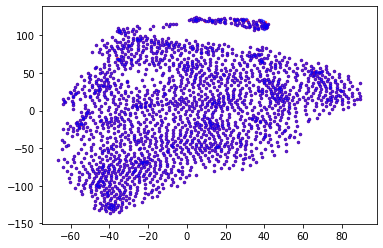

In [49]:
colors = ['red', 'blue']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(onri_feat2d[x,0], onri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

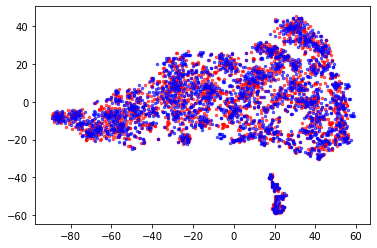

In [50]:
colors = ['red', 'blue']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(nri_feat2d[x,0], nri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

- Copy size == 3

In [25]:
ori_feat2d.shape

(6000, 2)

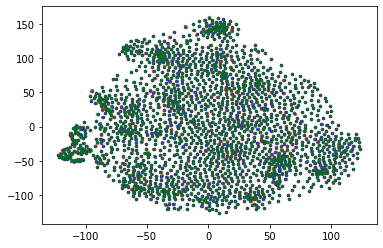

In [39]:
colors = ['red', 'blue', 'green']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(ori_feat2d[x,0], ori_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

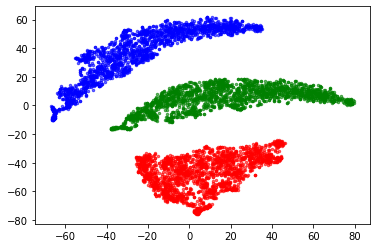

In [40]:
colors = ['red', 'blue', 'green']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(ri_feat2d[x,0], ri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

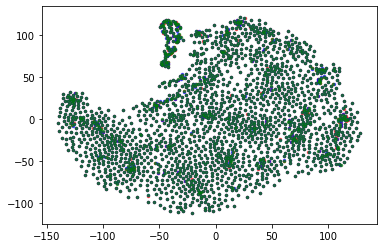

In [41]:
colors = ['red', 'blue', 'green']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(onri_feat2d[x,0], onri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

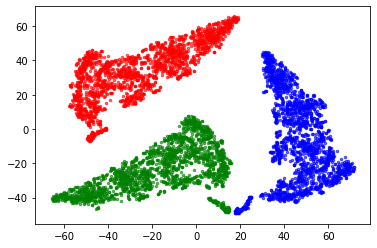

In [42]:
colors = ['red', 'blue', 'green']
plt.figure()
xlist = []
xdx = np.arange(0,oriencs.shape[0],1)
for idx, i in enumerate(range(len(colors))):
    x = np.where(  xdx % len(colors) == i)
    xlist.append(x)
    #print(x[0].shape)
    
    plt.scatter(nri_feat2d[x,0], nri_feat2d[x,1], color=colors[idx], s=6, alpha=0.6)
plt.show()

### Exanine data points which minimize distance before and after rotation

- Cluster == 90 copy_size == 90

Compute square distance over tsne mapping from ri encoder

In [166]:
from sklearn.metrics.pairwise import euclidean_distances

In [183]:
dist[0][0], dist.min()

(60.42211, 60.42211)

In [184]:
def compute_dist_fn(ifeat2d, jfeat2d):
    dist_list = []
    for i in range(ifeat2d.shape[0]):
        dist =  euclidean_distances(ifeat2d[i].reshape(1,-1), jfeat2d[i].reshape(1,-1))
        dist_list.append(dist.min()) # attach min method to extract value
    return np.asarray(dist_list)

Compute distance

In [185]:
dists = compute_dist_fn(ri_feat2d, ori_feat2d)

In [186]:
dists.shape

(9000,)

In [187]:
dist_index = np.argsort(dists)

In [188]:
dist_index[:100]

array([5563,  868, 6433, 1066, 7089, 1658, 3844, 5828, 2533,  238, 7091,
       2926, 1569, 6438, 5825, 6546, 6206, 7991, 5644, 8054, 5904, 6135,
       8810, 7177, 5009, 3461, 6171, 6879, 5744, 6110, 4734, 6156, 5169,
       4367, 2249, 2784, 8969, 7068, 2036,  134,  859, 1231, 2743,  810,
       2871,  545, 5900, 8578,   36, 4177, 5648,   63,  997, 5893, 7076,
       8475, 8655, 8325, 8682, 6095, 8871, 2237,  133, 1404, 7896, 5175,
       2989,  526, 1454, 2851, 7070,  812,  383, 7950, 7171, 3818, 1247,
       5678, 8748, 4391, 1475, 2742,  993, 1387, 8874, 8495, 8084, 7832,
       5888,  610, 4957, 4019, 5586, 8131, 8507, 7807, 8942, 8508, 1184,
       5535])

Visualize before and after

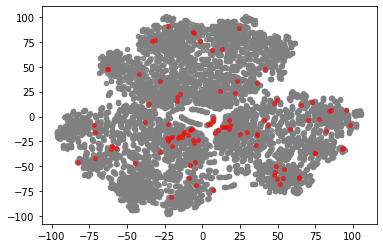

In [190]:
plt.figure()
first_npatches = 100
plt.scatter(ori_feat2d[dist_index[:],0],
            ori_feat2d[dist_index[:],1], color='grey', s=20, alpha=0.6)
plt.scatter(ori_feat2d[dist_index[:first_npatches],0],
            ori_feat2d[dist_index[:first_npatches],1], color='red', s=15, alpha=0.6)
plt.show()

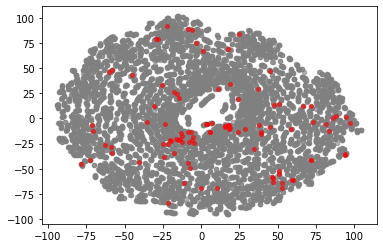

In [189]:
plt.figure()
first_npatches = 100
plt.scatter(ri_feat2d[dist_index[:],0],
            ri_feat2d[dist_index[:],1], color='grey', s=20, alpha=0.6)
plt.scatter(ri_feat2d[dist_index[:first_npatches],0],
            ri_feat2d[dist_index[:first_npatches],1], color='red', s=15, alpha=0.6)
plt.show()

Visualize patches

In [191]:
def load_latest_model(model_dir, mtype):
    #TODO add restart model dir and restart argument?
    latest = 0, None
    # get trained wegiht 
    for m in os.listdir(model_dir):
        if ".h5" in m and mtype in m:
            epoch = int(m.split("-")[1].replace(".h5", ""))
            latest = max(latest, (epoch, m))

    epoch, model_file = latest

    if not os.listdir(model_dir):
        raise NameError("no directory. check model path again")

    print(" Load {} at {} epoch".format(mtype, epoch))
    model_def = model_dir+'/'+mtype+'.json'
    model_weight = model_dir+'/'+mtype+'-'+str(epoch)+'.h5'
    with open(model_def, "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_weight)
    return model

In [193]:
model_dir = '/home/tkurihana/rotate_invariant/stepbystep/transform/output_model/67011582'
decoder = load_latest_model(model_dir, mtype='decoder')

 Load decoder at 100 epoch


In [197]:
ri_dimgs = decoder.predict(riencs) 
ri_dimgs.shape

(9000, 32, 32, 6)

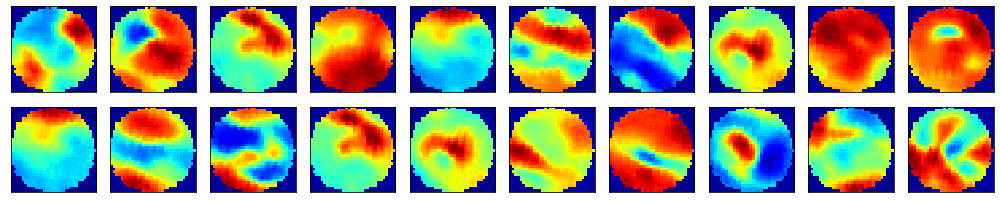

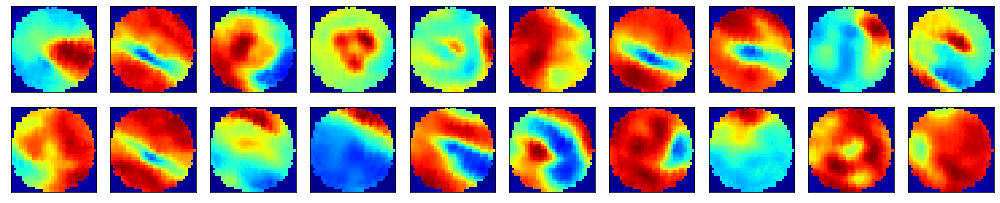

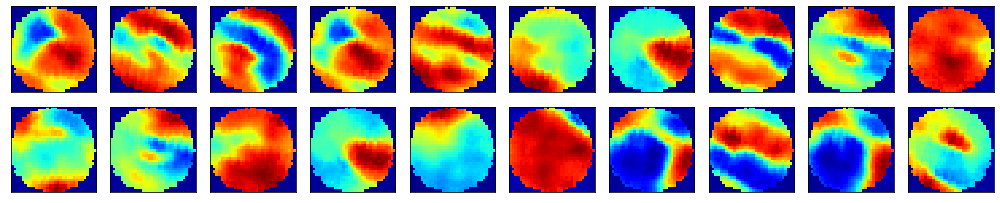

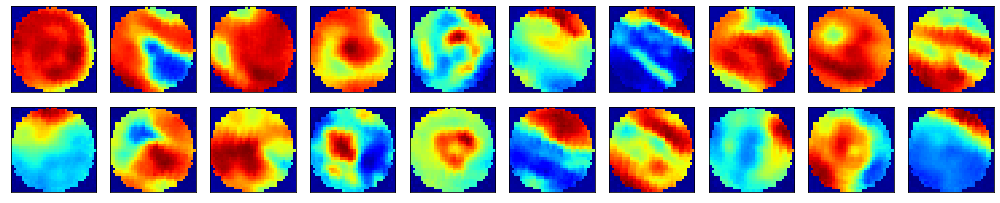

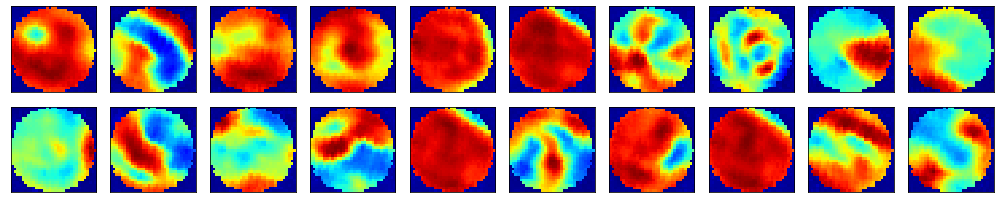

In [200]:
for subset in np.array_split(dist_index[:100],5) :
    fig = plt.figure(figsize=(14,3))
    for idx, i in enumerate(subset):
        ax = plt.subplot(2,10, idx+1)
        ax.imshow(ri_dimgs[i,:,:,0], cmap='jet')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        #ax.set_title(ronrilabels[i])
    fig.tight_layout()
    plt.show()
    plt.close()

Load original data to check the restoration

In [205]:
tf_datadir = "/project2/foster/clouds/data/clouds_laads_multiprocessed_2000_2018_band28_29_31_circle_2"

In [206]:
filelist = glob.glob(os.path.join(tf_datadir, '2-10*.tfrecord'))

In [207]:
nfiles = 1
fdx = np.random.randint(0,len(filelist),nfiles)
patches_list = []
for ifile in [filelist[i] for i in fdx]:
    patches_list.append(data_extractor_resize_fn([ifile],height=32,width=32,channel=6 ))
print("NORMAL END")

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
OutOfRage --> finish process
NORMAL END


In [208]:
patches = np.concatenate(
    [np.expand_dims(i, axis=0).reshape(1,32,32, 6) for i in patches_list[0]],
    axis=0)
patches.shape

(2000, 32, 32, 6)

In [212]:
sindex = np.load('./index_2-10_normed.npy')

In [214]:
begin = npatches = 100
spatches = np.squeeze(patches[sindex])
spatches = spatches[begin:begin+npatches]

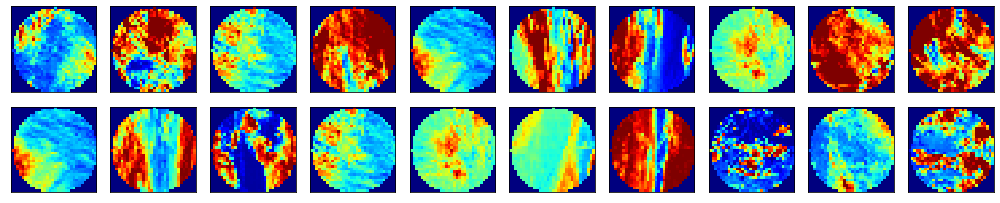

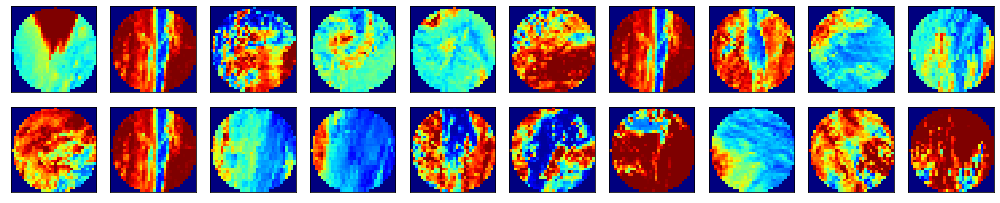

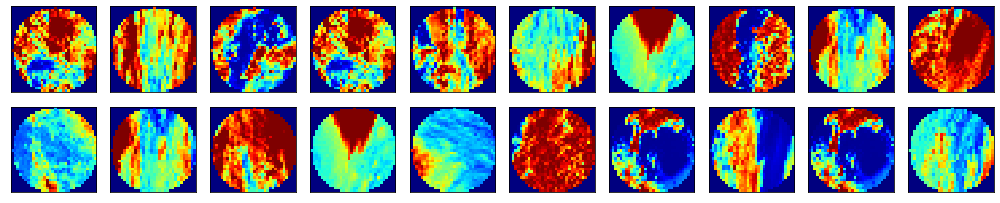

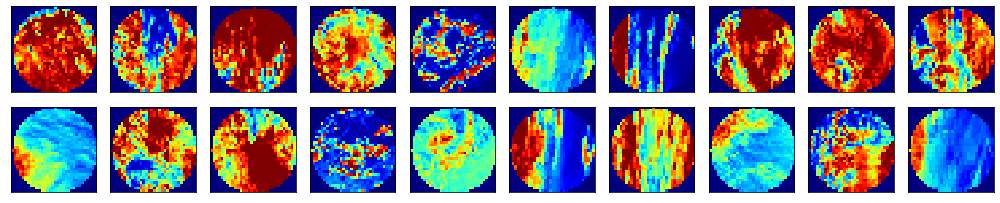

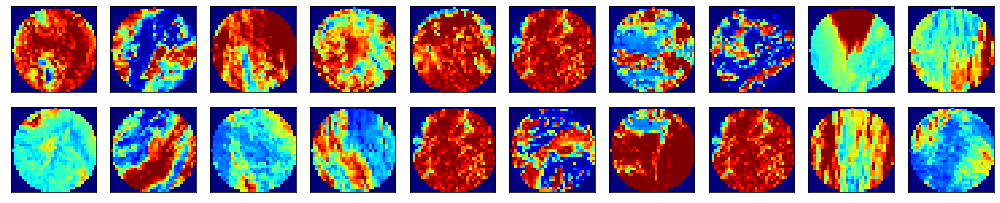

In [215]:
copy_size = 90
for subset in np.array_split(dist_index[:100],5) :
    fig = plt.figure(figsize=(14,3))
    for idx, i in enumerate(subset):
        ax = plt.subplot(2,10, idx+1)
        ax.imshow(spatches[i//copy_size,:,:,0], cmap='jet')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        #ax.set_title(ronrilabels[i])
    fig.tight_layout()
    plt.show()
    plt.close()